## Multi Armed Bandit Algorithm

* <b>A/B testing</b> is by far the most common way to gage user preference. Whenever a new user enters your site randomly assign them to one of the model versions you want to test. If I have two different beer recommenders I can run a controlled experiment, producing different recommendations for different users, then later switch to the recommender that performs the best on some metric like number of clicks. Cool stuff.


* The term <b>multi-armed bandit</b> comes from a theoretical problem where instead of one slot machine lever, you have a number of them, say three like in the image above. If you know the odds and payouts, it's trivial to determine the lever with the highest expected value. But imagine you didn't know the odds (like not knowing which model preforms best). A bandit algorithm attempts to solve this problem and maximize profit by systematically testing different levers and remembering the rewards.


* What the analogy of a multi-armed slot machine captures well is **it costs to test your hypotheses**. *A slot machine takes a coin to play. A website costs you a visit.* **Testing gains you knowledge, but will sometimes necessitate supplying your customers with an inferior product.** In response, **bandit algorithms** are **automated** to **move away from low scoring options and inherently prefer those that preform better**.


* *Of course you can do this with an **A/B test***. And if you're only going to **run one or two test over a short period of time which you track frequently, an A/B test will often perform just as well as a bandit algorithm**. *But as the number and length of hypotheses and tests increase, the advantage of an automatic feedback loop allows the designer to take a more hands off approach.*

### Epsilon-Greedy algorithm

* Despite its simplicity, the epsilon-greedy algorithm does a good job of encapsulating the spirit of bandit algorithms.


* Every time the algorithm has to choose an option (also referred to as an arm), it first considers two possibilities; explore or exploit.


*  Explore corresponds to testing, and if epsilon-greedy takes this path it simply chooses an arm at random. The exploit path on the other hand leads only to the arm with the best performance so far, the safe bet.


* The "best arm" is considered the option (in our case a recommendation model) with the highest probability of reward. I'll define my feedback system later, but for now think of reward as akin to clicks/viewsclicks/views.

<img src = "image002.jpg" style="height:300px;"/>

Standard A/B testing consists of

* A short period of pure exploration, in which you assign equal numbers of users to
Groups A and B.


* A long period of pure exploitation, in which you send all of your users to the more
successful version of your site and never come back to the option that seemed to be
inferior

Why might this be a bad strategy?

* It jumps discretely from exploration into exploitation, when you might be able to
smoothly transition between the two.

* During the purely exploratory phase, it wastes resources exploring inferior options
in order to gather as much data as possible. But you shouldn’t want to gather data
about strikingly inferior options.

**Advantage of MAB**

* they smoothly de‐crease the amount of exploring they do over time instead of requiring you to make a sudden jump.


* they focus your resources during exploration on the better options instead of wasting time on the inferior options that are over-explored during typical A/B testing. 

In [74]:
import random

def ind_max(x):
    m = max(x)
    return x.index(m)

class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return

    def select_arm(self):
        if random.random() > self.epsilon:
            return ind_max(self.values)
        else:
            return random.randrange(len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [72]:
random.randrange(10)

5

In [73]:
import random

class BernoulliArm():
    def __init__(self, p):
        self.p = p

    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [86]:
p_values = [0.1,0.1,0.1,0.1,0.9]
arms = list(map(lambda x: BernoulliArm(x), p_values))

### Debugging Bandit Algorithms

* Even though the last chapter contained a full implementation of the epsilon-Greedy algorithm, it was still a very abstract discussion because the algorithm was never run.


* The reason for that is simple: unlike standard machine learning tools, bandit algorithms aren’t simply black-box functions you can call to process the data you have lying around — bandit algorithms have to actively select which data you should acquire and
analyze that data in real-time. 


*  Indeed, **bandit algorithms** exemplify two types of learning that are not present in standard ML* examples: **active learning**, which refers to algorithms that actively select which data they should receive; and **online learning***, which refers to algorithms that analyze data in real-time and provide results on the fly.


* This means that there is a complicated feedback cycle in every bandit algorithm: as shown in Figure 4-1, the behavior of the algorithm depends on the data it sees, but the data the algorithm sees depends on the behavior of the algorithm. Debugging a bandit algorithm is therefore substantially more complicated than debugging a straight ma‐chine learning algorithm that isn’t doing active learning. 

<img src= "image.jpg" style = "height : 200px">

* In order to solve both of these problems, we’re going to use an alternative to standard
unit-testing that’s appropriate for testing bandit algorithms. This alternative is called
**Monte Carlo simulations**.

In [87]:
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]

    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))

        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t

            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward

            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

                algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [88]:
random.shuffle(p_values)
n_arms = len(p_values)
print("Best arm is " + str(ind_max(p_values)))

for epsilon in [0.2]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)

Best arm is 1


In [68]:
results[3]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0

In [97]:
chosen_arms = np.array(results[2])
chosen_arms = chosen_arms.reshape((250,5000),)
max_arm_perc = [np.sum(a == 4)/5000 for a in chosen_arms]

In [98]:
chosen_arms.shape

(250, 5000)

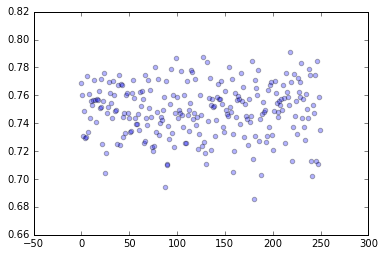

In [99]:
plt.scatter(np.arange(250), max_arm_perc, alpha = 0.3)

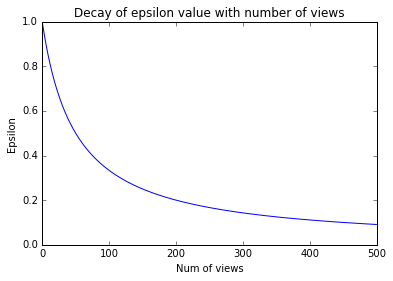

In [85]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
decay = 50
x = np.arange(500)
y = decay/(decay + x)
plt.plot(x,y)
plt.title("Decay of epsilon value with number of views")
plt.xlabel("Num of views")
plt.ylabel("Epsilon")